# Camera Positions
Replicating OpenGL's gluLookAt() in "inverse" for use with pyrender

In [1]:
import numpy as np
from math import pi, cos, sin
import matplotlib.pyplot as plt

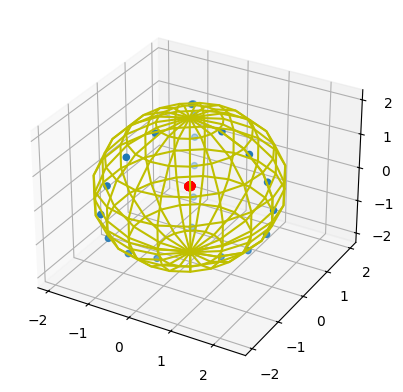

In [2]:
def generate_camera_positions(r=2, n_elev=8, n_azi=3):
    positions = []
    for i_a in range(n_azi):
        az = i_a * 2 * pi / n_azi
        for i_e in range(n_elev):
            el = i_e * pi / n_elev - pi / 2
            x = r * cos(el) * cos(az)
            y = r * cos(el) * sin(az)
            z = r * sin(el)
            positions.append(np.array((x, y, z)))

    return positions

test_pos = generate_camera_positions()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

xs, ys, zs = zip(*test_pos)
xs, ys, zs = np.array(xs), np.array(ys), np.array(zs)

max_range = np.array([xs.max() - xs.min(), ys.max() - ys.min(), zs.max() - zs.min()]).max()
Xb = 0.5 * max_range * np.mgrid[-1:2:2, -1:2:2, -1:2:2][0].flatten() + 0.5 * (xs.max() + xs.min())
Yb = 0.5 * max_range * np.mgrid[-1:2:2, -1:2:2, -1:2:2][1].flatten() + 0.5 * (ys.max() + ys.min())
Zb = 0.5 * max_range * np.mgrid[-1:2:2, -1:2:2, -1:2:2][2].flatten() + 0.5 * (zs.max() + zs.min())

for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], "w")

ax.scatter(xs, ys, zs)

u, v = np.mgrid[0 : 2 * np.pi : 20j, 0 : np.pi : 10j]
xs = np.cos(u) * np.sin(v) * 2
y = np.sin(u) * np.sin(v) * 2
z = np.cos(v) * 2
ax.plot_wireframe(xs, y, z, color="y")

u, v = np.mgrid[0 : 2 * np.pi : 20j, 0 : np.pi : 10j]
xs = np.cos(u) * np.sin(v) * 0.1
y = np.sin(u) * np.sin(v) * 0.1
z = np.cos(v) * 0.1
ax.plot(xs, y, z, color="r")

plt.show()

[[ 0.         -0.70710678 -0.70710678 -1.41421356]
 [ 0.          0.70710678 -0.70710678 -1.41421356]
 [ 1.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]


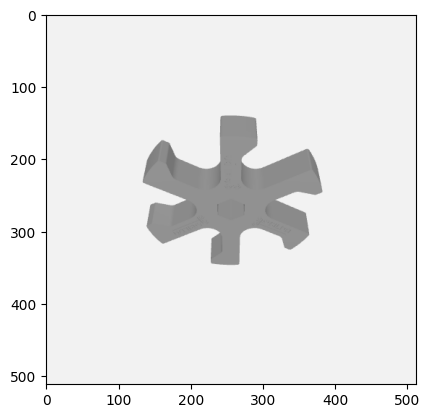

In [95]:
import trimesh
import pyrender

mesh = trimesh.load("models/BootWheel48OD.STEP", force="mesh")
mesh.apply_translation(-mesh.centroid)
scale = 0.8 / np.max(mesh.extents)
mesh.apply_scale(scale)

scene = pyrender.Scene(
    bg_color=[0.95, 0.95, 0.95, 1.0], ambient_light=[0.3, 0.3, 0.3, 1.0]
)

material = pyrender.MetallicRoughnessMaterial(
    baseColorFactor=[0.4, 0.4, 0.4, 1.0], metallicFactor=0.8, roughnessFactor=0.8
)

render_mesh = pyrender.Mesh.from_trimesh(mesh, material=material, smooth=False)
scene.add(render_mesh)
def generate_camera_poses(v_t=np.array((0, 0, 0))):
    poses = []
    positions = generate_camera_positions()
    for v_e in positions:
        forward = v_t - v_e
        forward /= np.linalg.norm(forward)

        up = np.array([0.0, 1.0, 0.0])
        right = np.cross(forward, up)
        right /= np.linalg.norm(right)

        true_up = np.cross(right, forward)

        # Build the rotation matrix
        rot = np.eye(4)
        rot[:3, 0] = right
        rot[:3, 1] = true_up
        rot[:3, 2] = -forward  # forward is -Z in OpenGL

        # Translation matrix
        trans = np.eye(4)
        trans[:3, 3] = v_e

        # Combine into camera-to-world matrix
        pose = trans @ rot  # Note: camera-to-world = T * R
        poses.append(pose)

    return poses

poses = generate_camera_poses()

camera_pose = poses[44]
print(camera_pose)

cam = pyrender.PerspectiveCamera(yfov=np.pi / 4.0)
scene.add(cam, pose=camera_pose)

light_pose = np.eye(4)
light_pose[:3, 3] = [0, 2, 0]
light = pyrender.PointLight(color=np.ones(3), intensity=5)
scene.add(light, pose=light_pose)

fill_light = pyrender.DirectionalLight(color=np.ones(3), intensity=5)
scene.add(fill_light, pose=camera_pose)

renderer = pyrender.OffscreenRenderer(viewport_width=512, viewport_height=512)

color, _ = renderer.render(scene)
plt.imshow(color)